In [1]:
import subprocess
import paramiko  
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import mygene
import json
from itertools import product
import itertools

In [2]:
# Declare credentials   
host = 'dragon.wurn.wustl.edu'   
username = 'arthurli'   
password = 'Zl121864'   
   
# Connect to server   
con = paramiko.SSHClient()   
con.load_system_host_keys()   
con.connect(host, username=username, password=password) 

In [3]:
# Run the command
def run_cmd(cmd):
  stdin, stdout, stderr = con.exec_command(cmd)
  # process the output   
  if stderr.read() == b'':   
      return stdout.readlines()   
  else:   
      return stderr.read()

# Read file from server into a list of lists
def read_file(file_dir):
    content = []
    sftp_client = con.open_sftp()
    remote_file = sftp_client.open(file_dir, bufsize=32768)
    remote_file.prefetch()
    
    try:
        for line in remote_file:
            # Split line by tab
            line_list = line.rstrip().split("\t")
            
            # Convert num to floats
            try:
                new_list = list(map(float, line_list[1:]))
                new_list.insert(0,line_list[0])
                content.append(new_list)
                
            # Append header
            except:
                content.append(line_list)
                pass
    finally:
        remote_file.close()
    return content


In [4]:
# Get list of dirs in each batch
keBYB3d4_dirs = [s.rstrip() for s in run_cmd("cd Karch_Data/202009_MGI_bulkRNAseq_/01.-RawData/htcf.wustl.edu/files/keBYB3d4/Karch_s4945A_MGI0337;ls")]
zdw3Pbdw_dirs = [s.rstrip() for s in run_cmd("cd Karch_Data/202009_MGI_bulkRNAseq_/01.-RawData/htcf.wustl.edu/files/zdw3Pbdw/Karch_s4945B_MGI0310;ls")]
print(keBYB3d4_dirs)

['10.1a.200.TGCGGCGT-CCTCGGTA', '10.1a.50.TCGTAGTG-AGACTTGG', '10.2a.200.CATAATAC-TTCTAACG', '10.2a.300.TGGCCGGT-TAGAGCGC', '10.2a.50.CTACGACA-GAGTCCAA', '10.3a.200.GATCTATC-ATGAGGCT', '10.3a.50.TAAGTGGT-CTTAAGCC', '10.4a.50.CGGACAAC-TCCGGATT', '11.1a.50.ATATGGAT-CTGTATTA', '11.1b.100.ATGGCATG-AAGGTACC', '11.2a.300.ATTGTGAA-TGCATTGC', '11.2a.50.GCGCAAGC-TCACGCCG', '11.2b.100.GCAATGCA-GGAACGTT', '11.3a.300.ACTCGTGT-ATTGGAAC', '11.3a.50.AAGATACT-ACTTACAT', '11.3b.100.GTTCCAAT-AATTCTGC', '11.4a.200.AGCTCGCT-GCAGAATC', '11.4a.300.GTCTACAC-GCCAAGGT', '11.4a.50.GGAGCGTC-GTCCGTGC', '11.4b.100.ACCTTGGC-GGCCTCAT', '12.1a.300.GCCACAGG-CATGCCAT', '12.4a.300.GACGTCTT-GGTTCACC', '13.1a.200.CGGAACTG-CACTACGA', '13.2a.200.TAAGGTCA-TGTCGTAG', '13.3a.200.TTGCCTAG-ACCACTTA', '13.4a.200.CCATTCGA-GTTGTCCG', '14.1a.100.ATATCTCG-ATCTTAGT', '14.1a.200.ACACTAAG-ATCCATAT', '14.2a.100.GCGCTCTA-GCTCCGAC', '14.2a.200.GTGTCGGA-GCTTGCGC', '14.2a.300.TGCGAGAC-CATTGTTG', '14.3a.100.AACAGGTT-ATACCAAG', '14.3a.200.TTCC

In [5]:
# Read in a list of sample info
sample_df = pd.read_csv('Karch MGI Sample Submission 092020 Phenotypes.csv')
display(sample_df)
sample_names = list(sample_df["Sample Name"])
cvs_tissue_types = list(sample_df["Tissue Type"])

unique_tissue_types = [i for j, i in enumerate(cvs_tissue_types) if i not in cvs_tissue_types[:j]] 
print(unique_tissue_types)

# Select the sample in csv from dirs
selected_full_dirs = [] # list of full dirs to process
tissue_types = []
for i in range(len(sample_names)):
    for j in range(len(keBYB3d4_dirs)):
        if sample_names[i].lower() == keBYB3d4_dirs[j][0:-18].lower():
            selected_full_dirs.append("Karch_Data/202009_MGI_bulkRNAseq_/01.-RawData/htcf.wustl.edu/files/keBYB3d4/Karch_s4945A_MGI0337/"+keBYB3d4_dirs[j])
            tissue_types.append(cvs_tissue_types[i])
    for k in range(len(zdw3Pbdw_dirs)):
        if sample_names[i].lower() == zdw3Pbdw_dirs[k][0:-18].lower():
            selected_full_dirs.append("Karch_Data/202009_MGI_bulkRNAseq_/01.-RawData/htcf.wustl.edu/files/zdw3Pbdw/Karch_s4945B_MGI0310/"+zdw3Pbdw_dirs[k])
            tissue_types.append(cvs_tissue_types[i])

,Sample Name,Alternative Line Name,Cell Type,DIV,Concentration (ng/ul),Volume,Species,Final Harmonized Sample Name,Source,Genotype,Tissue Type
0,9.1a.50,9.1a,3D,50,113.026667,15.00,Human,9.1a.50^iOrg,UCL-Wray,NaN,Organoid
1,9.2a.50,9.2a,3D,50,110.573333,15.00,Human,9.2a.50^iOrg,UCL-Wray,NaN,Organoid
2,9.3a.50,9.3a,3D,50,120.613333,15.00,Human,9.3a.50^iOrg,UCL-Wray,NaN,Organoid
3,9.4a.50,9.4a,3D,50,494.040000,15.00,Human,9.4a.50^iOrg,UCL-Wray,NaN,Organoid
4,10.1a.50,10.1a,3D,50,122.613333,15.00,Human,10.1a.50^iOrg,UCL-Wray,NaN,Organoid
...,...,...,...,...,...,...,...,...,...,...,...
174,6,6,Superior Temporal Gyrus,.,136.510000,14.65,Human,SMRI_6,Stanley Medical Research Institute (SMRI),.,Brain
175,58,58,Superior Temporal Gyrus,.,102.440000,19.52,Human,SMRI_58,Stanley Medical Research Institute (SMRI),.,Brain
176,5,5,Superior Temporal Gyrus,.,114.890000,17.41,Human,SMRI_5,Stanley Medical Research Institute (SMRI),.,Brain
177,4,4,Superior Temporal Gyrus,.,104.760000,19.09,Human,SMRI_4,Stanley Medical Research Institute (SMRI),.,Brain


['Organoid', 'Neuron', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL', 'Brain']


In [6]:
# Define a dictionary of cell types with gene markers (original)
cell_gene_markers={"astrocyte":["AQP4", "GJA1", "GFAP", "SOX9", "ALDH1L1", "ADGRL4"], 
                   "microglia":["IL1A", "P2RY13", "GPR34", "SPI1", "CSF1R", "CX3CR1", "P2RY12", "AIF1", "IRF8", "TGFBR1", "TLR2", "ADGRG1", "SAXL"], 
                   "neuron":["STMN2", "SYT1", "SYN1", "GAD1", "CCK"],
                   "oligodendrocyte":["GPR37", "PLP1", "MOG", "MOBP", "SOX10"]}
display(cell_gene_markers)

{'astrocyte': ['AQP4', 'GJA1', 'GFAP', 'SOX9', 'ALDH1L1', 'ADGRL4'],
 'microglia': ['IL1A',
  'P2RY13',
  'GPR34',
  'SPI1',
  'CSF1R',
  'CX3CR1',
  'P2RY12',
  'AIF1',
  'IRF8',
  'TGFBR1',
  'TLR2',
  'ADGRG1',
  'SAXL'],
 'neuron': ['STMN2', 'SYT1', 'SYN1', 'GAD1', 'CCK'],
 'oligodendrocyte': ['GPR37', 'PLP1', 'MOG', 'MOBP', 'SOX10']}

In [7]:
# Average TPM for gene markers associated with each celltype 
# Data structure: {'Organoid1':{'astrocyte':[ave_TPM, ave_NumReads, ...], ...}, ...}
result_dic = {}

# If result jason already exists
try:
    with open('Ave_TPM_NumReads_Results.json', 'r') as fp:
        result_dic = json.load(fp)
    gene_df = pd.read_csv('gene_id_table.csv')
    display(gene_df.head())
    display(result_dic)
except:
    # Create a counting dict for samples with different cell types
    sam_count_dic = {'Organoid':0, 'Neuron':0, 'Microglia':0, 'Neurons':0, 'Astrocyte':0, 'hMacrophage':0, 'hMGL':0, 'Brain':0}
    for i in range(len(selected_full_dirs)):
        sam_count_dic[tissue_types[i]] += 1

        file_dir = selected_full_dirs[i]+"/"+selected_full_dirs[i].split('/')[-1]+".quant.sf" # Create file dir

        salmon_content = read_file(file_dir) # Read sf
        salmon_df = pd.DataFrame(salmon_content[1:], columns = salmon_content[0]) # Convert sf to df

        # Get a list of dictionaries with gene names from the initial list of ensemble transcript ids
        if i == 0:
            try:
                gene_df = pd.read_csv('gene_id_table.csv')
            except:
                ENSTs = np.array(salmon_df["Name"])
                mg = mygene.MyGeneInfo()
                gene_df = mg.querymany(ENSTs, scopes='ensembl.transcript', species='human', as_dataframe=True)
                gene_df.to_csv('gene_id_table.csv', index=False)
            display(gene_df)


        # Replace the ensemble ids with gene names
        salmon_df["Name"] = gene_df["symbol"]

        # Only leave the valid genes that are present
        salmon_df = salmon_df.dropna()
        salmon_df = salmon_df[salmon_df["NumReads"] != 0].reset_index(drop=True)

        # Check if tissue type changes
        if sam_count_dic[tissue_types[i]] == 2:
            #Plot hist
            salmon_df.hist(figsize=(12, 8), bins=20)
            plt.show()

        print("Processing "+tissue_types[i]+str(sam_count_dic[tissue_types[i]]))
        
        print(file_dir, "\n")
        # Populate the result dic with the cell types and their TPM and NumReads averages
        result_dic[tissue_types[i]+str(sam_count_dic[tissue_types[i]])]={}
        for cell_type, marker_list in cell_gene_markers.items():
            marker_df = salmon_df[salmon_df['Name'].isin(marker_list)] # Select marker-associated df
            result_dic[tissue_types[i]+str(sam_count_dic[tissue_types[i]])][cell_type] = [marker_df["TPM"].mean(), marker_df["NumReads"].mean()]

        # Update last tissue type
        last_tissue_type = tissue_types[i]

        # Dirs with problem: I3.300.2, i10.300.3
    with open('Ave_TPM_NumReads_Results.json', 'w') as fp:
        json.dump(result_dic, fp)

,_id,_score,name,symbol,taxid,notfound,entrezgene
0,ENSG00000228985,23.341190,T cell receptor delta diversity 3,TRDD3,9606.0,NaN,NaN
1,ENSG00000223997,23.281755,T cell receptor delta diversity 1,TRDD1,9606.0,NaN,NaN
2,ENSG00000237235,23.340570,T cell receptor delta diversity 2,TRDD2,9606.0,NaN,NaN
3,ENSG00000233655,23.281755,immunoglobulin heavy diversity 4-4,IGHD4-4,9606.0,NaN,NaN
4,ENSG00000211911,23.341026,immunoglobulin heavy diversity 3-22,IGHD3-22,9606.0,NaN,NaN


{'Organoid1': {'astrocyte': [28.43750739466667, 182.86666247933329],
  'microglia': [6.3251222134481475, 40.29630529111296],
  'neuron': [26.1122315, 157.49999625],
  'oligodendrocyte': [4.949074666666666, 30.22219666666667]},
 'Organoid2': {'astrocyte': [30.85798347058823, 261.47058870588234],
  'microglia': [6.095165736743378, 56.466636068289326],
  'neuron': [12.27985, 82.75001937500001],
  'oligodendrocyte': [3.6137338, 26.25000665]},
 'Organoid3': {'astrocyte': [21.396973658391843, 132.84208952231356],
  'microglia': [5.4238859917559585, 35.06521558729822],
  'neuron': [25.987043112030673, 141.53331452922],
  'oligodendrocyte': [2.8484364578947363, 14.1052812]},
 'Organoid4': {'astrocyte': [11.586248561751649, 130.76922746592712],
  'microglia': [3.5401594725075567, 40.711112230584035],
  'neuron': [24.411643357142857, 274.99949357142856],
  'oligodendrocyte': [2.3990058311764706, 25.41176353488235]},
 'Organoid5': {'astrocyte': [20.875079857142858, 165.35714228571425],
  'microgl

Text(0, 0.5, 'Relative Cell Proportion')

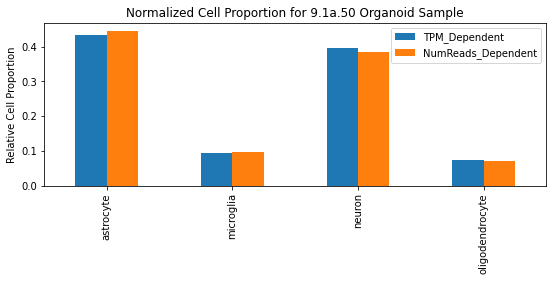

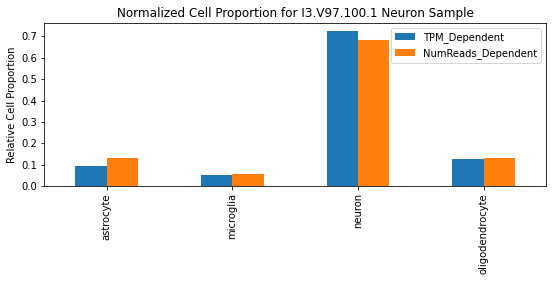

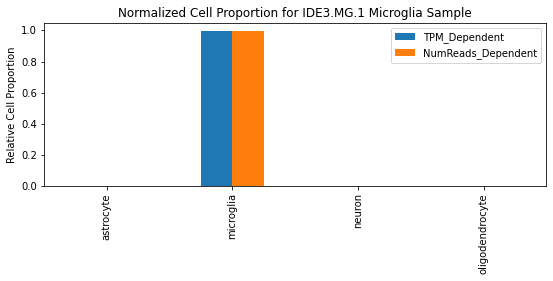

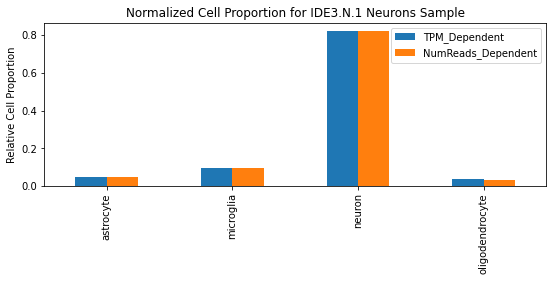

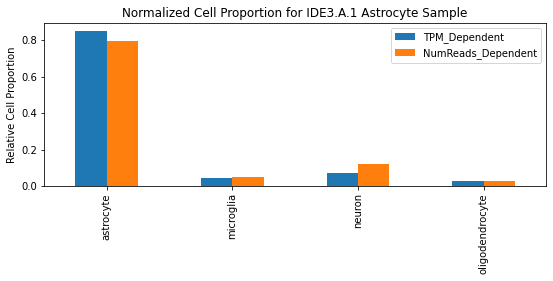

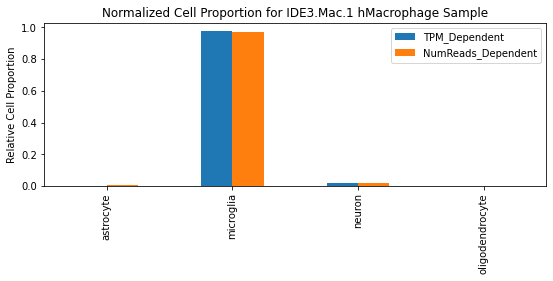

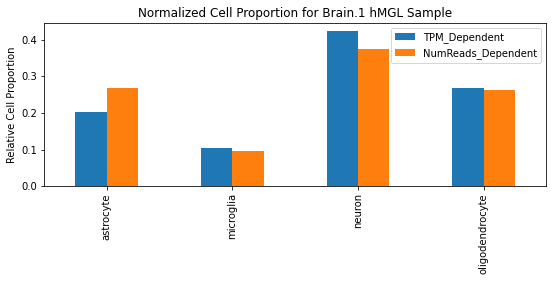

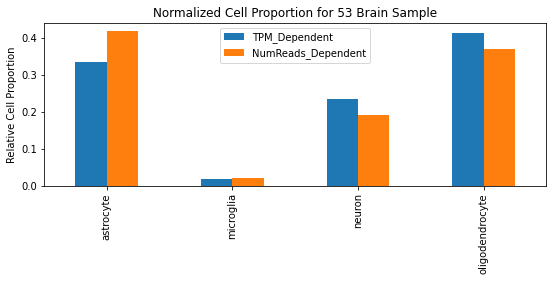

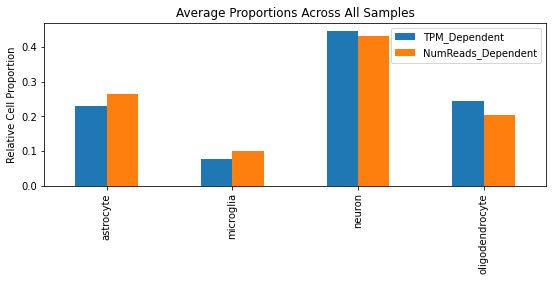

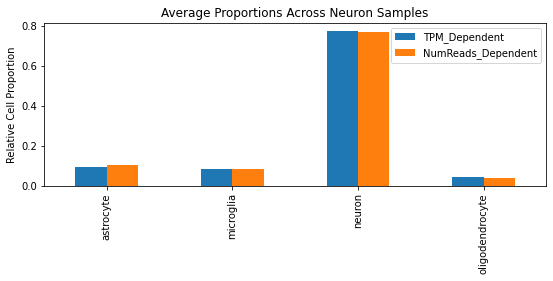

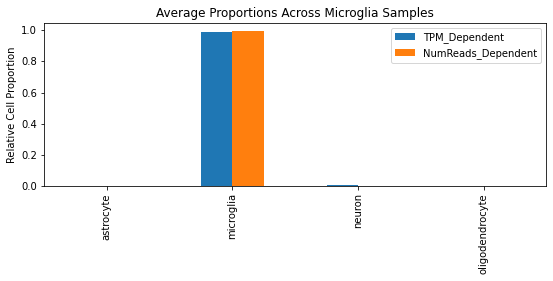

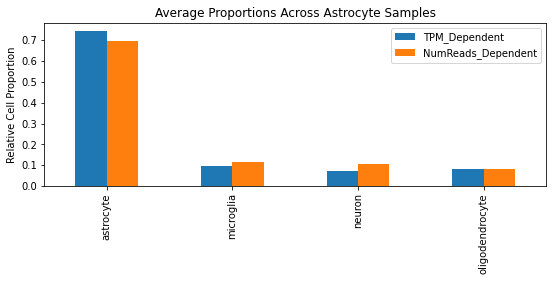

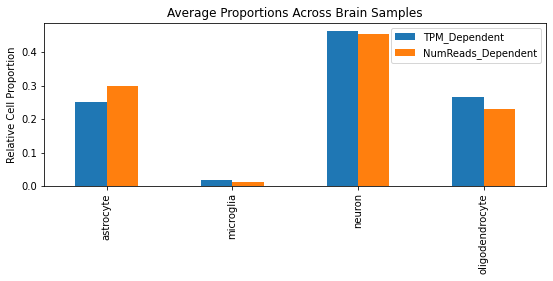

In [8]:
def normalize_cell_proportion(dic, cols=["TPM", "NumReads"]):
    # Convert dic to dataframe
    result_df = pd.DataFrame(list(dic.values()), index=dic.keys(), columns=cols)
    result_df = result_df.fillna(0)
    # Normalize by sum
    result_df = result_df/result_df.sum()
    return result_df

def normalize_cell_proportion_ave(selected_tissues):
    sam_count = 0
    across_sample_sum = pd.DataFrame([[0, 0],[0, 0],[0, 0],[0, 0]], index=result_dic["Organoid1"].keys(), columns=["TPM", "NumReads"])
    for sam, prop in result_dic.items():
        if ''.join([i for i in sam if not i.isdigit()]) in selected_tissues:
            across_sample_sum += pd.DataFrame(list(prop.values()), index=prop.keys(), columns=["TPM", "NumReads"])
            across_sample_sum = across_sample_sum.fillna(0)
            sam_count += 1

    across_sample_ave = across_sample_sum/sam_count
    return across_sample_ave/across_sample_ave.sum()


# Plot a few samples of results
for tissue_type in unique_tissue_types:
    normalize_cell_proportion(result_dic[tissue_type+"1"]).plot.bar(figsize=(9, 3))
    plt.title("Normalized Cell Proportion for "+sample_df[sample_df["Tissue Type"] == tissue_type].iloc[0]["Sample Name"]+" "+tissue_type+" Sample")
    plt.ylabel("Relative Cell Proportion")
    
    
# Plot the cell abundance across selected samples associated with specific tissue type(s)
normalize_cell_proportion_ave(['Organoid', 'Neuron', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL', 'Brain']).plot.bar(figsize=(9, 3))
plt.title("Average Proportions Across All Samples")
plt.ylabel("Relative Cell Proportion")

normalize_cell_proportion_ave(['Neurons']).plot.bar(figsize=(9, 3))
plt.title("Average Proportions Across Neuron Samples")
plt.ylabel("Relative Cell Proportion")

normalize_cell_proportion_ave(['Microglia']).plot.bar(figsize=(9, 3))
plt.title("Average Proportions Across Microglia Samples")
plt.ylabel("Relative Cell Proportion")

normalize_cell_proportion_ave(['Astrocyte']).plot.bar(figsize=(9, 3))
plt.title("Average Proportions Across Astrocyte Samples")
plt.ylabel("Relative Cell Proportion")

normalize_cell_proportion_ave(['Brain']).plot.bar(figsize=(9, 3))
plt.title("Average Proportions Across Brain Samples")
plt.ylabel("Relative Cell Proportion")

Completed:
* Established remote server connection and was able to run ssh command in python 
  (so Python machine learning libraries like sklearn, keras, and tensorflow can be used, and novel model/architecture    can be built)
* Converted transcript ids to gene names
* Matched gene names to the gene markers for each cell type
* Took averages of TPM and NumReads associated with each cell type
* Normalized the averages across astrocyte, microglia, neuron, and oligodendrocyte
* Ploted the normalized averages to suggest relative cell proportions
* Located the table of samples in csv on Fenix server
* Used TPM to determine relative proportion of cells in samples
* Current # of samples: 180


Next:
    1. Extract more features from the database
    2. Experiment with machine learning models for regression problem:
        Goal: Predict on relative cell proportions
        Rationale: Take consideration across all samples and make more accurate predictions
        Choices:
            (a) Non-deep-learning (eg. SVR, Elastic net, and Lasso):
                Pro: More samples are preferable but not required
                Con: Less accurate
            (b) Deep learning (ANN is preferable for the tabular dataset):
                Pro: More accurate
                Con: More samples are required (100000+ is recomended)       
    3. Use the most accurate model to make predictions on cell proportions
       Advantage: 
           (a) Only need a single vector with required values to make predictions
           (b) Have a clear measure of accuracy
           (c) Instantaneously output cell proportionsc for quick analysis     
    4. Compare the predictions with those from "ssFrobenius" and "meanProfile"
    5. Implement clustering on transcripts across all samples to oberve correlations

In [9]:
# First try if the file for clustering exists
try:
    processed_sf_df = pd.read_csv('processed_salmon.csv')
except:
    # Create a counting dict for samples with different cell types
    sam_count_dic = {'Organoid':0, 'Neuron':0, 'Microglia':0, 'Neurons':0, 'Astrocyte':0, 'hMacrophage':0, 'hMGL':0, 'Brain':0}
    for i in range(len(selected_full_dirs)):
        sam_count_dic[tissue_types[i]] += 1

        file_dir = selected_full_dirs[i]+"/"+selected_full_dirs[i].split('/')[-1]+".quant.sf" # Create file dir

        salmon_content = read_file(file_dir) # Read sf
        salmon_df = pd.DataFrame(salmon_content[1:], columns = salmon_content[0]) # Convert sf to df

        # Replace the ensemble ids with gene names
        salmon_df["Name"] = gene_df["symbol"]

        # Only leave the valid genes that are present
        salmon_df = salmon_df.dropna()
        salmon_df = salmon_df[salmon_df["NumReads"] != 0].reset_index(drop=True)

        print("Processing "+tissue_types[i]+str(sam_count_dic[tissue_types[i]]))
        print(file_dir, "\n")

        salmon_df.insert(loc=len(salmon_df.columns), column='Tissue Type', value=[tissue_types[i]]*len(salmon_df))
        salmon_df.insert(loc=len(salmon_df.columns), column='Gene Marker', value=["Unclassified"]*len(salmon_df))

        # Populate the result dic with the cell types and their TPM and NumReads averages
        for cell_type, marker_list in cell_gene_markers.items():
            salmon_df.loc[salmon_df['Name'].isin(marker_list), "Gene Marker"] = cell_type
            
        salmon_df.to_csv("processed_salmon.csv", mode='a', index=False)
        
        

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
processed_sf_df = processed_sf_df.drop(processed_sf_df.loc[processed_sf_df['TPM'] == 'TPM'].index)

# Convert TPM and NumReads to floats
processed_sf_df["TPM"] = processed_sf_df["TPM"].astype(float)
processed_sf_df["NumReads"] = processed_sf_df["NumReads"].astype(float)

# Normalize TPM and NumReads
# processed_sf_df['TPM'] = processed_sf_df['TPM'].div(processed_sf_df['TPM'].max())
# processed_sf_df['NumReads'] = processed_sf_df['NumReads'].div(processed_sf_df['NumReads'].max())

# Drop rows with zero expressions
processed_sf_df = processed_sf_df.drop(processed_sf_df.loc[(processed_sf_df['TPM'] == 0)|(processed_sf_df['NumReads']== 0)].index)



In [11]:
def get_gene_expression(tissue_types=['Organoid', 'Neuron', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL', 'Brain'], gene_markers=['microglia', 'neuron', 'astrocyte', 'oligodendrocyte']):
    expr_dic = {} # Dictionary of dfs for different tissues and genes
    
    # Put gene TPM and NumReads dfs associated with the tissue types into the dict
    for tissue in tissue_types:
        expr_dic[tissue+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == tissue)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
    
    # Put gene TPM and NumReads dfs associated with the gene markers into the dict
    for marker in gene_markers:
        expr_dic[marker+"_df"] = processed_sf_df.loc[(processed_sf_df['Gene Marker'] == marker)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
    
    # Put gene TPM and NumReads dfs associated with the combination of the tissue types gene markers into the dict
    tg_comb = list(product(tissue_types, gene_markers)) # Get the combination
    for comb in tg_comb:
        expr_dic[comb[0]+"_"+comb[1]+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == comb[0]) & (processed_sf_df['Gene Marker'] == comb[1])].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()

    return expr_dic

def tissue_gene_expression_plot(tissue_types =['Organoid', 'Neuron', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL', 'Brain'], gene_markers=['microglia', 'neuron', 'astrocyte', 'oligodendrocyte'], colors=["blue", "green", "orange", "purple", "black"]):
    for tissue in tissue_types:
        legend=[]
        # All genes in the microglia tissue type
        plt.figure(figsize=(18, 7))
        plt.subplot(1, 2, 1)
        
        # Sort the df based on TPM and NumReads
        expr_df = expr_dic[tissue+"_df"].sort_values(by=['TPM', 'NumReads'], ascending=False).reset_index(drop=True)
        x=expr_df["NumReads"]
        y=expr_df["TPM"]
        names=expr_df["Name"]
        plt.scatter(x, y, color="grey", alpha=0.3)
        legend.append("all genes expressed: "+str(len(expr_dic[tissue+"_df"])))
        for i, txt in enumerate(names):
            plt.annotate(txt, (x[i], y[i]))
            if i == 15:
                break
                
        for j in range(len(gene_markers)):
            c=colors[j]
            if gene_markers[j].lower() == tissue.lower():
                c="red"
                plt.subplot(1, 2, 2)
                plt.scatter(expr_dic[tissue+"_"+gene_markers[j]+"_df"]["NumReads"], expr_dic[tissue+"_"+gene_markers[j]+"_df"]["TPM"], color=c, alpha=0.3)
                plt.title("(b) Mean "+tissue+" Gene Marker Expression Levels across "+tissue+" Samples")
                plt.xlabel("Number of Reads")
                plt.ylabel("TPM")
            # Gene markers in the microglia tissue type
            plt.subplot(1, 2, 1)
            plt.scatter(expr_dic[tissue+"_"+gene_markers[j]+"_df"]["NumReads"], expr_dic[tissue+"_"+gene_markers[j]+"_df"]["TPM"], color=c, alpha=0.3)
            legend.append(gene_markers[j]+" markers: "+str(len(expr_dic[tissue+"_"+gene_markers[j]+"_df"])))
        
        plt.title("(a) Mean Gene Expression Levels across "+tissue+" Samples")
        plt.xlabel("Number of Reads")
        plt.ylabel("TPM")
        plt.legend(legend)
        plt.show()



<ipython-input-11-a86bbc3d1b4c>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[tissue+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == tissue)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
<ipython-input-11-a86bbc3d1b4c>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[marker+"_df"] = processed_sf_df.loc[(processed_sf_df['Gene Marker'] == marker)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
<ipython-input-11-a86bbc3d1b4c>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[comb[0]+"_"+comb[1]+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == comb[0]) & (processed_sf_df['Gene Marker'] == comb[1])].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()


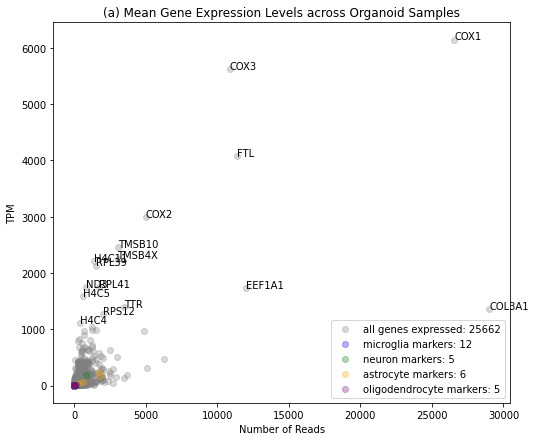

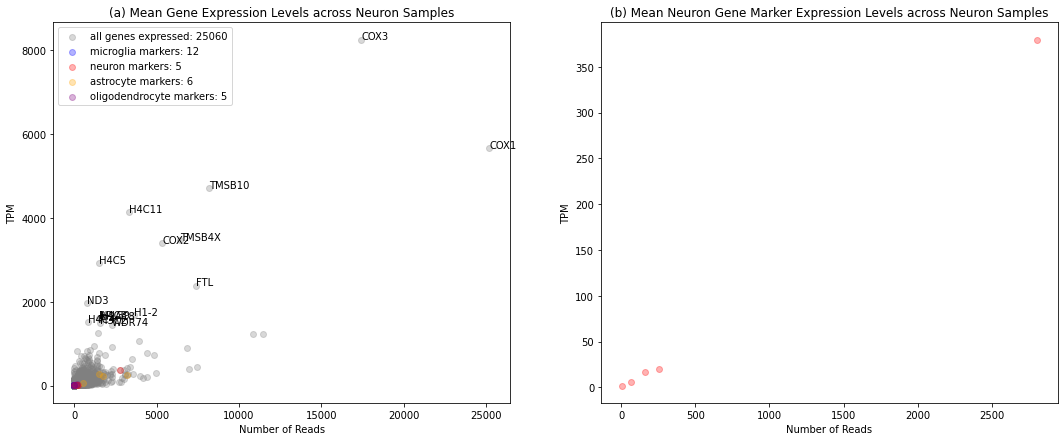

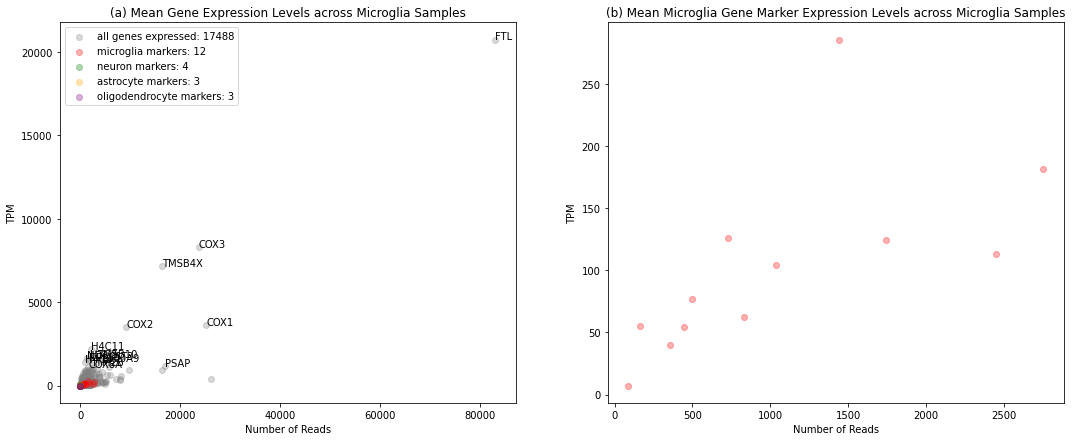

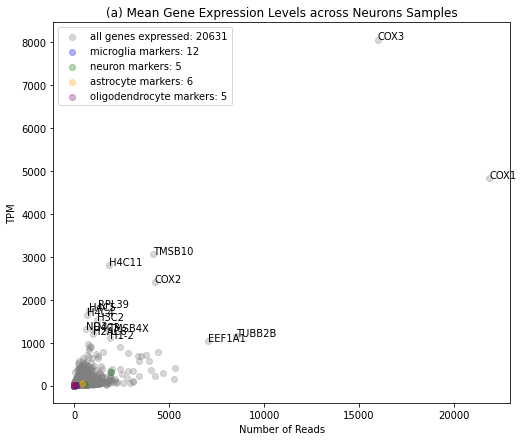

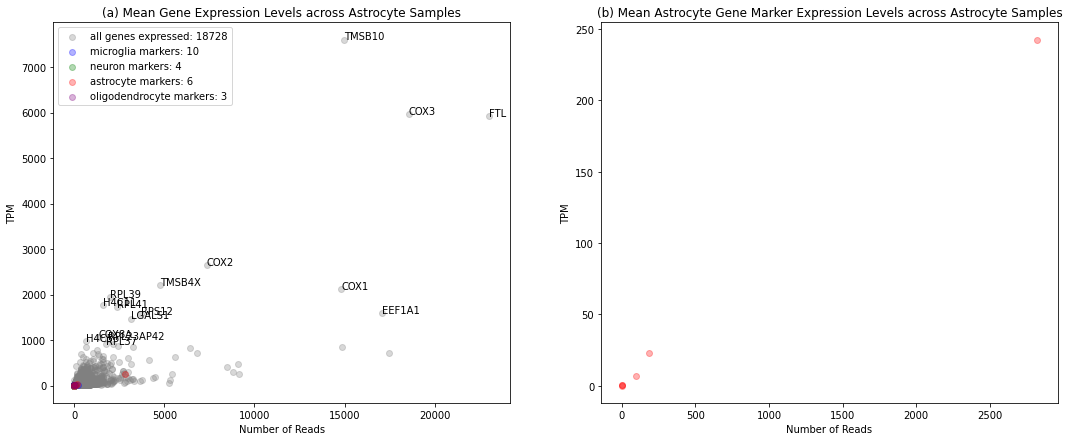

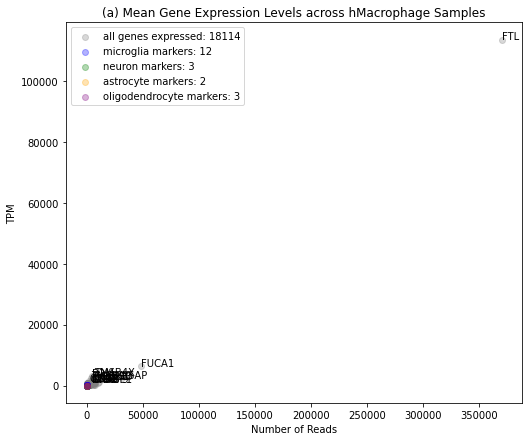

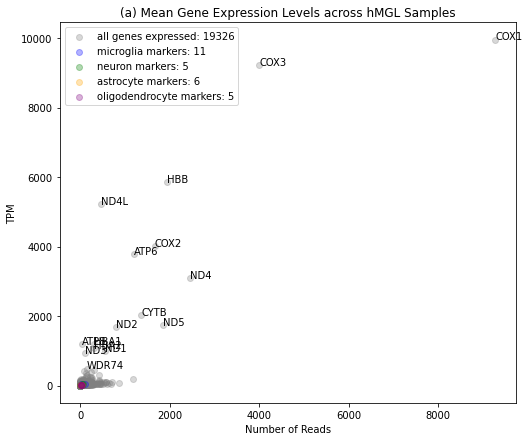

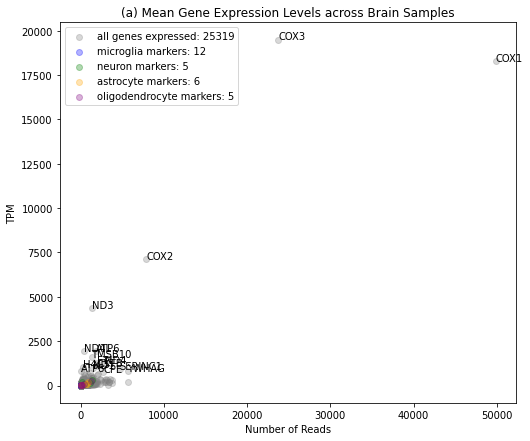

In [12]:
expr_dic = get_gene_expression()
tissue_gene_expression_plot()

Completed:
* Fixed problems of incorrect proportions for various tissue types
* Obtained plots for normalized proportions average acrross all samples, and samples associated with different tissue types
* Started implementing clustering on transcripts (all and markers) across samples ssociated with different tissue types to oberve correlations
* Made scatterplots of the transcripts
* Found and plotted highly expressed genes for various tissue types, which appear to be common human genes (e.g. COX)

Next:
    1. Filter out the genes that are ouside the min and max thresholds of existing markers
    2. Extract the genes that are highly expressed in one tissue type but not others
    3. Compare the extracted genes to existing markers and attempt to use them as markers
    4. Observe if each tissue type has higher cell proportions associated with the type
    5. Extract more features from the database
    6. Experiment with machine learning models for regression problem:
        Goal: Predict on relative cell proportions
        Rationale: Take consideration across all samples and make more accurate predictions
        Choices:
            (a) Non-deep-learning (eg. SVR, Elastic net, and Lasso):
                Pro: More samples are preferable but not required
                Con: Less accurate
            (b) Deep learning (ANN is preferable for the tabular dataset):
                Pro: More accurate
                Con: More samples are required (100000+ is recomended)       
    7. Use the most accurate model to make predictions on cell proportions
       Advantage: 
           (a) Only need a single vector with required values to make predictions
           (b) Have a clear measure of accuracy
           (c) Instantaneously output cell proportionsc for quick analysis     
    8. Compare the predictions with those from "ssFrobenius" and "meanProfile"

In [13]:
def per_diff(v1, v2):
    return ((v1-v2)/((v1+v2)/2))*100

def per_change(v1, v2):
    return (v1-v2)/np.abs(v2)
        
def get_gene_markers(existing_markers = ['microglia', 'neuron', 'astrocyte', 'oligodendrocyte'], cell_types =['Organoid', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'Astrocyte', 'hMGL'], num_markers=10, treshold=True, flex=0.2, quant_method="TPM"):
    quant_range = []# contain the quantification range (TPM or NumReads) to be filtered
    if treshold:
        quant_vals = [] # contain max and mins of all existing marker dfs
        for marker in existing_markers:
            quant_vals.append(expr_dic[marker+"_df"].groupby('Name').mean().reset_index()[quant_method].min())
            quant_vals.append(expr_dic[marker+"_df"].groupby('Name').mean().reset_index()[quant_method].max())

        quant_range.append(min(quant_vals)-min(quant_vals)*flex)
        quant_range.append(max(quant_vals)+max(quant_vals)*flex)
        
        # Filter out rows out of range
        for cell in cell_types:
            sam_df = expr_dic[cell+"_df"].groupby('Name').mean().reset_index()
            expr_dic[cell+"_df"] =  sam_df[(sam_df[quant_method] > quant_range[0]) & (sam_df[quant_method] < quant_range[1])]

    quant_dic={} # {"cell_type":[[gene_name, mean_diff, mean_diff_range], ...]], ...}
    for cell1 in cell_types:
        quant_list=[]
        row=[]
        sam_df1 = expr_dic[cell1+"_df"].groupby('Name').mean().reset_index()
        sam_df1 = sam_df1.sort_values(by=['Name']).reset_index(drop=True)
        gene_names=sam_df1["Name"]
        
        quant_vals_list = []
        quant_bool_list = []
        quant_mag_list = []
        quant_vals_percen_diff_list = []
        for cell2 in cell_types:
            if cell1 is not cell2:
  
                sam_df2 = expr_dic[cell2+"_df"].groupby('Name').mean().reset_index()
                sam_df2 = sam_df2[sam_df2['Name'].isin(sam_df1['Name'])]
                
                sam_df1_unique_names = np.array(sam_df1[~sam_df1['Name'].isin(sam_df2['Name'])]["Name"])
                sam_df2 = sam_df2.append(pd.DataFrame(sam_df1_unique_names, columns=["Name"]), ignore_index=True).fillna(0)
                
                sam_df2 = sam_df2.sort_values(by=['Name']).reset_index(drop=True)
                
                
                percent_diff = per_change(np.array(sam_df1[quant_method]), np.array(sam_df2[quant_method]))

                quant_vals_percen_diff_list.append(np.array((percent_diff)))
        
                
                quant_bool_list.append(np.logical_and(sam_df1[quant_method]!=0, sam_df2[quant_method]==0).astype(int))
                quant_mag_list.append(np.array(sam_df1[quant_method]))
  
                quant_vals_list.append(np.array(sam_df1[quant_method]-sam_df2[quant_method]))
                
                if cell1=="":
                    display(sam_df1[sam_df1["Name"]=="ADGRG5"])
                    display(sam_df2[sam_df2["Name"]=="ADGRG5"])
                    

        # display(max(np.mean(quant_vals_percen_diff_list, axis=0)))
        # quant_dic[cell1] = pd.DataFrame({"Name":gene_names, "Mean "+quant_method+" Percent Diff":np.min(quant_vals_percen_diff_list, axis=0), "Mean "+quant_method+" Abs Diff":np.min(quant_vals_list, axis=0), quant_method+" Abs Diff Range":np.ptp(quant_vals_list, axis=0)}).sort_values(by=["Mean "+quant_method+" Percent Diff"], ascending=False).reset_index(drop=True)
        # quant_dic[cell1] = pd.DataFrame({"Name":gene_names, "Mean "+quant_method+" Percent Diff":np.min(quant_vals_percen_diff_list, axis=0), "Mean "+quant_method+" Abs Diff":np.min(quant_vals_list, axis=0), quant_method+" Abs Diff Range":np.ptp(quant_vals_list, axis=0)}).sort_values(by=["Mean "+quant_method+" Abs Diff"], ascending=False).reset_index(drop=True)
        
        # diff_norm = np.max(np.min(quant_vals_percen_diff_list, axis=0))/np.max(np.min(quant_vals_list, axis=0))
        # quant_dic[cell1] = pd.DataFrame({"Name":gene_names, "Diff":(np.min(quant_vals_percen_diff_list, axis=0)+(diff_norm*np.min(quant_vals_list, axis=0)))/2, quant_method+" Abs Diff Range":np.ptp(quant_vals_list, axis=0)}).sort_values(by=["Diff"], ascending=False).reset_index(drop=True).head(50)

        result_df = pd.DataFrame({"Name":gene_names, "Marker for "+cell1+"?":(np.sum(quant_bool_list, axis=0) == len(quant_bool_list)), "Mean "+quant_method:np.mean(quant_mag_list, axis=0)})
        quant_dic[cell1] = result_df[result_df["Marker for "+cell1+"?"]==True].sort_values(by=["Mean "+quant_method], ascending=False).reset_index(drop=True)

    return quant_dic
        
        
        
# cell_types = ['Organoid', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL']
cell_types = ['Microglia', 'Neurons', 'Astrocyte', 'hMacrophage']
cell_gene_markers = {}
# quant_dic = get_gene_markers(treshold=False)
# for cell in cell_types:
#     quant_df = quant_dic[cell]
#     display(quant_df)
#     cell_gene_markers[cell.lower()] = list(quant_df[quant_df["Mean TPM Percent Diff"]==float("inf")].sort_values(by=["Mean TPM Abs Diff"], ascending=False).head(10)["Name"])

quant_dic = get_gene_markers()
for cell in cell_types:
    quant_df = get_gene_markers(treshold=False)[cell]
    display(quant_df)
    cell_gene_markers[cell.lower()] = list(quant_df.head(10)["Name"])

<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:

,Name,Marker for Microglia?,Mean TPM
0,ACY3,True,273.675406
1,CD1C,True,159.705706
2,CD207,True,79.343167
3,IL1A,True,54.096122
4,LTC4S,True,30.468531
...,...,...,...
75,TNFRSF4,True,2.619740
76,HSPE1P7,True,2.596250
77,TNFRSF8,True,2.547059
78,TDRD15,True,2.538678


<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:

,Name,Marker for Neurons?,Mean TPM
0,TTR,True,265.852177
1,P2RX3,True,51.200772
2,CRH,True,46.768800
3,ALPG,True,35.067387
4,RPS29P4,True,33.750500
...,...,...,...
193,NDUFB9P1,True,2.525000
194,SENP8,True,2.522912
195,RSL24D1P6,True,2.520540
196,BMS1P12,True,2.517254


<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:

,Name,Marker for Astrocyte?,Mean TPM
0,MT1L,True,72.586538
1,MEDAG,True,64.089281
2,LUM,True,43.687815
3,TNFRSF6B,True,32.738762
4,EBF2,True,21.490625
...,...,...,...
59,IL11,True,2.660560
60,SDR42E1P4,True,2.620630
61,PTGER1,True,2.619662
62,MOCOS,True,2.519384


<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (v1-v2)/np.abs(v2)
<ipython-input-13-a6bdcfd72b25>:

,Name,Marker for hMacrophage?,Mean TPM
0,TM4SF19,True,119.203068
1,TRAC,True,65.710714
2,MARCO,True,58.637698
3,CXCL9,True,55.619057
4,IGKC,True,52.297814
...,...,...,...
223,IL2RB,True,2.529162
224,SULT1C2,True,2.527960
225,KCNA10,True,2.510199
226,PGLYRP4,True,2.508010


In [14]:
cell_gene_markers

{'microglia': ['ACY3',
  'CD1C',
  'CD207',
  'IL1A',
  'LTC4S',
  'TIFAB',
  'KCNK17',
  'LGALS12',
  'ADGRG5',
  'CCR6'],
 'neurons': ['TTR',
  'P2RX3',
  'CRH',
  'ALPG',
  'RPS29P4',
  'LIN28A',
  'AMBN',
  'BEND4',
  'DPPA3',
  'VN1R85P'],
 'astrocyte': ['MT1L',
  'MEDAG',
  'LUM',
  'TNFRSF6B',
  'EBF2',
  'MEOX2',
  'SIX1',
  'RPS26P40',
  'MAP7D3',
  'SYNC'],
 'hmacrophage': ['TM4SF19',
  'TRAC',
  'MARCO',
  'CXCL9',
  'IGKC',
  'IGHM',
  'CCL8',
  'KCNJ5',
  'OTOAP1',
  'SIGLEC1']}

In [49]:
# Average TPM for gene markers associated with each celltype 
# Data structure: {'Organoid1':{'astrocyte':[ave_TPM, ave_NumReads, ...], ...}, ...}
result_dic = {}

# If result jason already exists
# 8
try:
    with open('Ave_TPM_NumReads_Results_With_New_Markers_Bool6.json', 'r') as fp:
        result_dic = json.load(fp)
    gene_df = pd.read_csv('gene_id_table.csv')
    display(gene_df.head())
    display(result_dic)
except:
    # Create a counting dict for samples with different cell types
    sam_count_dic = {'Organoid':0, 'Neuron':0, 'Microglia':0, 'Neurons':0, 'Astrocyte':0, 'hMacrophage':0, 'hMGL':0, 'Brain':0}
    for i in range(len(selected_full_dirs)):
        sam_count_dic[tissue_types[i]] += 1

        file_dir = selected_full_dirs[i]+"/"+selected_full_dirs[i].split('/')[-1]+".quant.sf" # Create file dir

        salmon_content = read_file(file_dir) # Read sf
        salmon_df = pd.DataFrame(salmon_content[1:], columns = salmon_content[0]) # Convert sf to df

        # Get a list of dictionaries with gene names from the initial list of ensemble transcript ids
        if i == 0:
            try:
                gene_df = pd.read_csv('gene_id_table.csv')
            except:
                ENSTs = np.array(salmon_df["Name"])
                mg = mygene.MyGeneInfo()
                gene_df = mg.querymany(ENSTs, scopes='ensembl.transcript', species='human', as_dataframe=True)
                gene_df.to_csv('gene_id_table.csv', index=False)
            display(gene_df)


        # Replace the ensemble ids with gene names
        salmon_df["Name"] = gene_df["symbol"]

        # Only leave the valid genes that are present
        salmon_df = salmon_df.dropna()
        salmon_df = salmon_df[salmon_df["NumReads"] != 0].reset_index(drop=True)

        # Check if tissue type changes
        if sam_count_dic[tissue_types[i]] == 2:
            #Plot hist
            salmon_df.hist(figsize=(12, 8), bins=20)
            plt.show()

        print("Processing "+tissue_types[i]+str(sam_count_dic[tissue_types[i]]))
        
        print(file_dir, "\n")
        # Populate the result dic with the cell types and their TPM and NumReads averages
        result_dic[tissue_types[i]+str(sam_count_dic[tissue_types[i]])]={}
        for cell_type, marker_list in cell_gene_markers.items():
            marker_df = salmon_df[salmon_df['Name'].isin(marker_list)] # Select marker-associated df
            result_dic[tissue_types[i]+str(sam_count_dic[tissue_types[i]])][cell_type] = [marker_df["TPM"].mean(), marker_df["NumReads"].mean()]

        # Update last tissue type
        last_tissue_type = tissue_types[i]

        # Dirs with problem: I3.300.2, i10.300.3
    with open('Ave_TPM_NumReads_Results_With_New_Markers_Bool6.json', 'w') as fp:
        json.dump(result_dic, fp)

,_id,_score,name,symbol,taxid,notfound,entrezgene
0,ENSG00000228985,23.341190,T cell receptor delta diversity 3,TRDD3,9606.0,NaN,NaN
1,ENSG00000223997,23.281755,T cell receptor delta diversity 1,TRDD1,9606.0,NaN,NaN
2,ENSG00000237235,23.340570,T cell receptor delta diversity 2,TRDD2,9606.0,NaN,NaN
3,ENSG00000233655,23.281755,immunoglobulin heavy diversity 4-4,IGHD4-4,9606.0,NaN,NaN
4,ENSG00000211911,23.341026,immunoglobulin heavy diversity 3-22,IGHD3-22,9606.0,NaN,NaN


{'Organoid1': {'microglia': [1.6311400000000003, 2.5431399999999997],
  'neurons': [1891.6827152857145, 4438.284257142857],
  'astrocyte': [374.2767428615, 1296.00002613],
  'hmacrophage': [nan, nan]},
 'Organoid2': {'microglia': [1.7956713250000003, 8.126066775],
  'neurons': [2627.179123333334, 7617.16275],
  'astrocyte': [377.86797366666656, 1482.1668250000002],
  'hmacrophage': [nan, nan]},
 'Organoid3': {'microglia': [0.8763215, 2.0686825],
  'neurons': [1364.183464285714, 2738.2867757142853],
  'astrocyte': [145.17346714285716, 440.5717142857143],
  'hmacrophage': [nan, nan]},
 'Organoid4': {'microglia': [2.91148, 17.3987625],
  'neurons': [9.265392166666667, 36.333308333333335],
  'astrocyte': [8.0328045, 50.233183333333336],
  'hmacrophage': [nan, nan]},
 'Organoid5': {'microglia': [1.3605496666666668, 3.865323333333334],
  'neurons': [1024.447468, 2626.1247625],
  'astrocyte': [143.3064216666667, 572.5000883333332],
  'hmacrophage': [1.9847455, 3.5]},
 'Organoid6': {'microglia

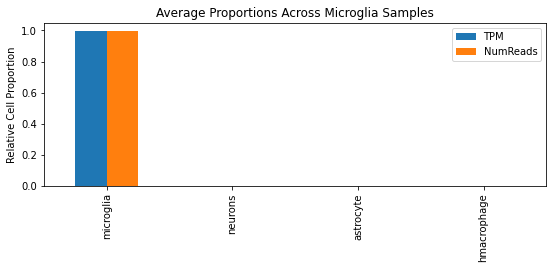

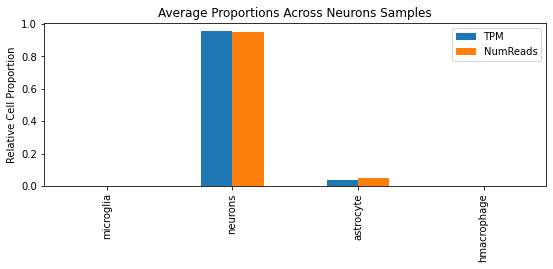

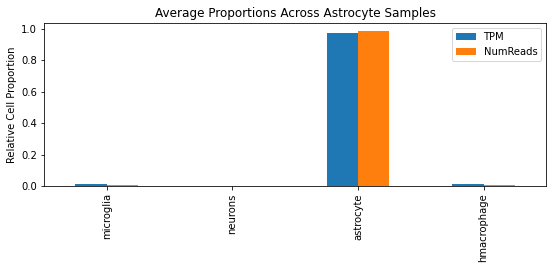

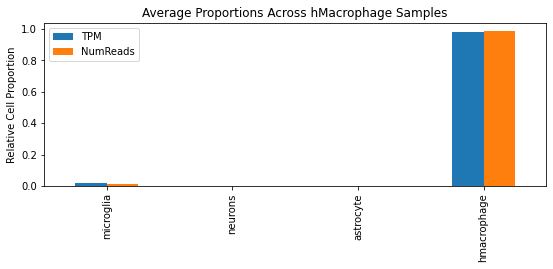

In [50]:
def normalize_cell_proportion(dic, cols=["TPM", "NumReads"]):
    # Convert dic to dataframe
    result_df = pd.DataFrame(list(dic.values()), index=dic.keys(), columns=cols)
    result_df = result_df.fillna(0)
    # Normalize by sum
    result_df = result_df/result_df.sum()

    return result_df

def normalize_cell_proportion_ave(selected_tissues):
    sam_count = 0
    across_sample_sum = pd.DataFrame([[0, 0],[0, 0],[0, 0],[0, 0]], index=result_dic["Organoid1"].keys(), columns=["TPM", "NumReads"])
    for sam, prop in result_dic.items():
        if ''.join([i for i in sam if not i.isdigit()]) in selected_tissues:
            across_sample_sum += pd.DataFrame(list(prop.values()), index=prop.keys(), columns=["TPM", "NumReads"])
            across_sample_sum = across_sample_sum.fillna(0)
            sam_count += 1

    across_sample_ave = across_sample_sum/sam_count
    return across_sample_ave/across_sample_ave.sum()


# # Plot a few samples of results
# for tissue_type in unique_tissue_types:
#     normalize_cell_proportion(result_dic[tissue_type+"1"]).plot.bar(figsize=(9, 3))
#     plt.title("Normalized Cell Proportion for "+sample_df[sample_df["Tissue Type"] == tissue_type].iloc[0]["Sample Name"]+" "+tissue_type+" Sample")
#     plt.ylabel("Relative Cell Proportion")
    
    
# Plot the cell abundance across selected samples associated with specific tissue type(s)
# normalize_cell_proportion_ave(['Organoid', 'Neuron', 'Microglia', 'Neurons', 'Astrocyte', 'hMacrophage', 'hMGL', 'Brain']).plot.bar(figsize=(9, 3))
# plt.title("Average Proportions Across All Samples")
# plt.ylabel("Relative Cell Proportion")

# Plot cell abundance for each type of samples
for cell in cell_types:
    normalize_cell_proportion_ave(cell).plot.bar(figsize=(9, 3))
    plt.title("Average Proportions Across "+cell+" Samples")
    plt.ylabel("Relative Cell Proportion")

Completed:
* Designed the algorithm that extracts gene markers based on absolute differences, percent differences, or 
  differential gene expression
* Implemented the functionality that can filter out the genes that are ouside the min and max thresholds of 
  existing markers
* Extracted the genes that are highly expressed in one tissue type but not others 
* Optimized the parameters that lead to better deconvolution results
* Selected the currently optimal methods
* Performed cellular deconvolution based on the extracted genes
* Plotted cell proportions using the deconvolution results
* Achieved > 95% empirical accuracy for the four cell types tested

Next:
1. Compare the extracted genes to existing markers
2. Observe if the result patterns generated from meanProfile/ssFrobeniun can be replicated when using the same 
   data
3. Extract more features from the database
4. Experiment with machine learning models for regression problem:
    Goal: Predict on relative cell proportions
    Rationale: Take consideration across all samples and make more accurate predictions
    Choices:
        (a) Non-deep-learning (eg. SVR, Elastic net, and Lasso):
            Pro: More samples are preferable but not required
            Con: Less accurate
        (b) Deep learning (ANN is preferable for the tabular dataset):
            Pro: More accurate
            Con: More samples are required (100000+ is recomended)       
5. Use the most accurate model to make predictions on cell proportions
   Advantage: 
       (a) Only need a single vector with required values to make predictions
       (b) Have a clear measure of accuracy
       (c) Instantaneously output cell proportionsc for quick analysis     
6. Compare the predictions with those from "ssFrobenius" and "meanProfile"

In [48]:
# Define the new extracted genes
cell_gene_markers = {'microglia': ['ACY3',
  'CD1C',
  'CD207',
  'IL1A',
  'LTC4S',
  'TIFAB',
  'KCNK17',
  'LGALS12',
  'ADGRG5',
  'CCR6'],
 'neurons': ['TTR',
  'P2RX3',
  'CRH',
  'ALPG',
  'RPS29P4',
  'LIN28A',
  'AMBN',
  'BEND4',
  'DPPA3',
  'VN1R85P'],
 'astrocyte': ['MT1L',
  'MEDAG',
  'LUM',
  'TNFRSF6B',
  'EBF2',
  'MEOX2',
  'SIX1',
  'RPS26P40',
  'MAP7D3',
  'SYNC'],
 'hmacrophage': ['TM4SF19',
  'TRAC',
  'MARCO',
  'CXCL9',
  'IGKC',
  'IGHM',
  'CCL8',
  'KCNJ5',
  'OTOAP1',
  'SIGLEC1']}

pd.DataFrame(cell_gene_markers.values(), index=cell_gene_markers.keys()) 

,0,1,2,3,4,5,6,7,8,9
microglia,ACY3,CD1C,CD207,IL1A,LTC4S,TIFAB,KCNK17,LGALS12,ADGRG5,CCR6
neurons,TTR,P2RX3,CRH,ALPG,RPS29P4,LIN28A,AMBN,BEND4,DPPA3,VN1R85P
astrocyte,MT1L,MEDAG,LUM,TNFRSF6B,EBF2,MEOX2,SIX1,RPS26P40,MAP7D3,SYNC
hmacrophage,TM4SF19,TRAC,MARCO,CXCL9,IGKC,IGHM,CCL8,KCNJ5,OTOAP1,SIGLEC1


In [26]:
# First try if the file for clustering exists
try:
    processed_sf_df = pd.read_csv('processed_salmon_new_markers.csv')
except:
    # Create a counting dict for samples with different cell types
    sam_count_dic = {'Organoid':0, 'Neuron':0, 'Microglia':0, 'Neurons':0, 'Astrocyte':0, 'hMacrophage':0, 'hMGL':0, 'Brain':0}
    for i in range(len(selected_full_dirs)):
        sam_count_dic[tissue_types[i]] += 1

        file_dir = selected_full_dirs[i]+"/"+selected_full_dirs[i].split('/')[-1]+".quant.sf" # Create file dir

        salmon_content = read_file(file_dir) # Read sf
        salmon_df = pd.DataFrame(salmon_content[1:], columns = salmon_content[0]) # Convert sf to df

        # Replace the ensemble ids with gene names
        salmon_df["Name"] = gene_df["symbol"]

        # Only leave the valid genes that are present
        salmon_df = salmon_df.dropna()
        salmon_df = salmon_df[salmon_df["NumReads"] != 0].reset_index(drop=True)

        print("Processing "+tissue_types[i]+str(sam_count_dic[tissue_types[i]]))
        print(file_dir, "\n")

        salmon_df.insert(loc=len(salmon_df.columns), column='Tissue Type', value=[tissue_types[i]]*len(salmon_df))
        salmon_df.insert(loc=len(salmon_df.columns), column='Gene Marker', value=["Unclassified"]*len(salmon_df))

        # Populate the result dic with the cell types and their TPM and NumReads averages
        for cell_type, marker_list in cell_gene_markers.items():
            salmon_df.loc[salmon_df['Name'].isin(marker_list), "Gene Marker"] = cell_type
            
        salmon_df.to_csv("processed_salmon_new_markers.csv", mode='a', index=False)
        
        

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
processed_sf_df = processed_sf_df.drop(processed_sf_df.loc[processed_sf_df['TPM'] == 'TPM'].index)

# Convert TPM and NumReads to floats
processed_sf_df["TPM"] = processed_sf_df["TPM"].astype(float)
processed_sf_df["NumReads"] = processed_sf_df["NumReads"].astype(float)

# Normalize TPM and NumReads
processed_sf_df['TPM'] = processed_sf_df['TPM'].div(processed_sf_df['TPM'].max())
processed_sf_df['NumReads'] = processed_sf_df['NumReads'].div(processed_sf_df['NumReads'].max())

# Drop rows with zero expressions
processed_sf_df = processed_sf_df.drop(processed_sf_df.loc[(processed_sf_df['TPM'] == 0)|(processed_sf_df['NumReads']== 0)].index)

<ipython-input-11-a86bbc3d1b4c>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[tissue+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == tissue)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
<ipython-input-11-a86bbc3d1b4c>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[marker+"_df"] = processed_sf_df.loc[(processed_sf_df['Gene Marker'] == marker)].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()
<ipython-input-11-a86bbc3d1b4c>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  expr_dic[comb[0]+"_"+comb[1]+"_df"] = processed_sf_df.loc[(processed_sf_df['Tissue Type'] == comb[0]) & (processed_sf_df['Gene Marker'] == comb[1])].groupby('Name', as_index=False)['TPM', 'NumReads'].mean()


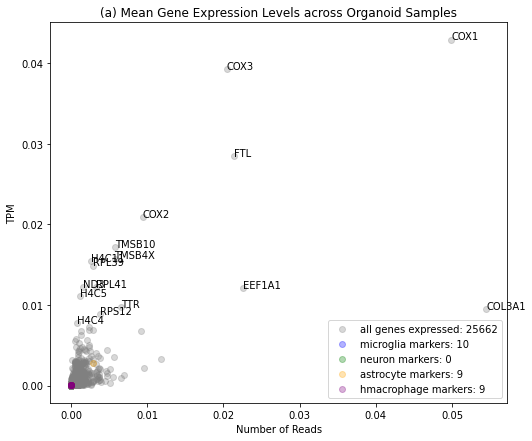

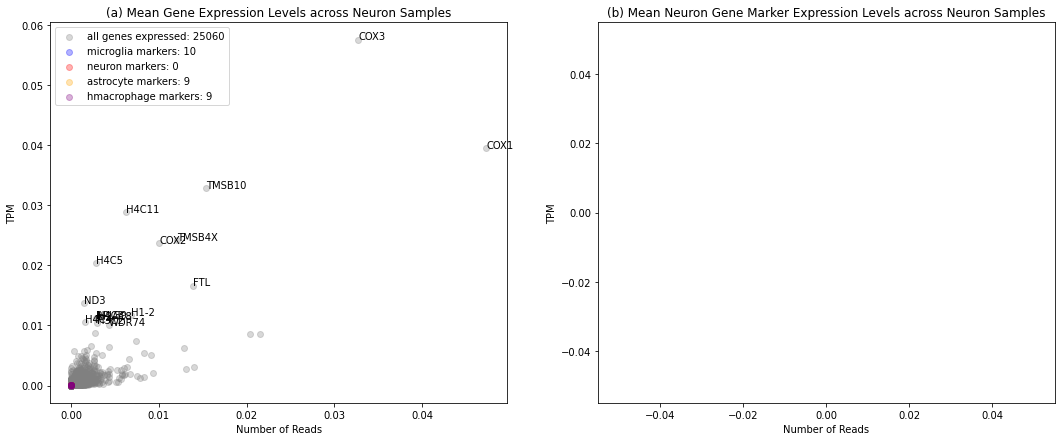

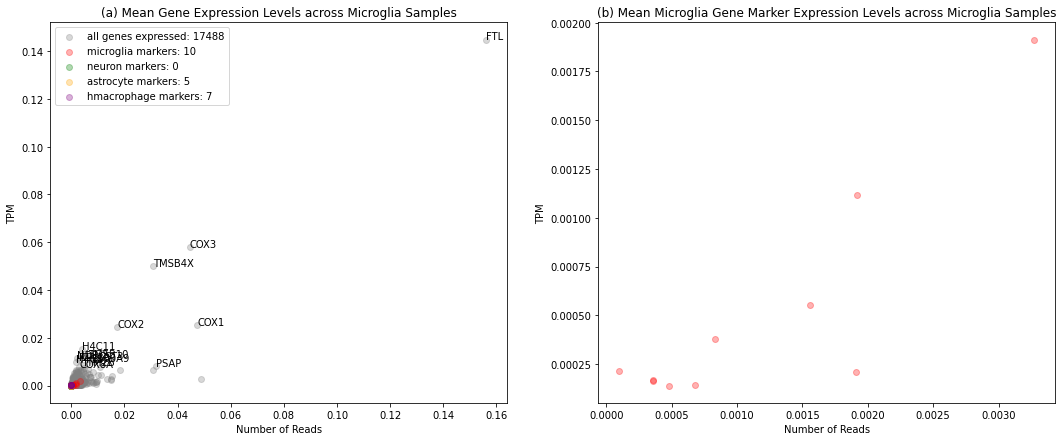

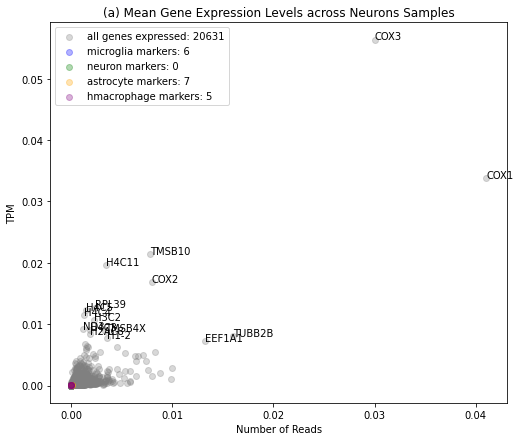

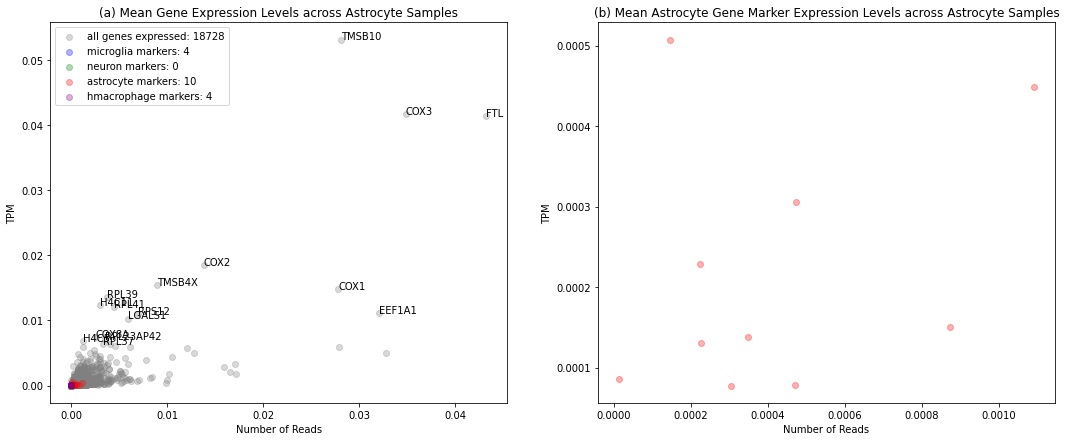

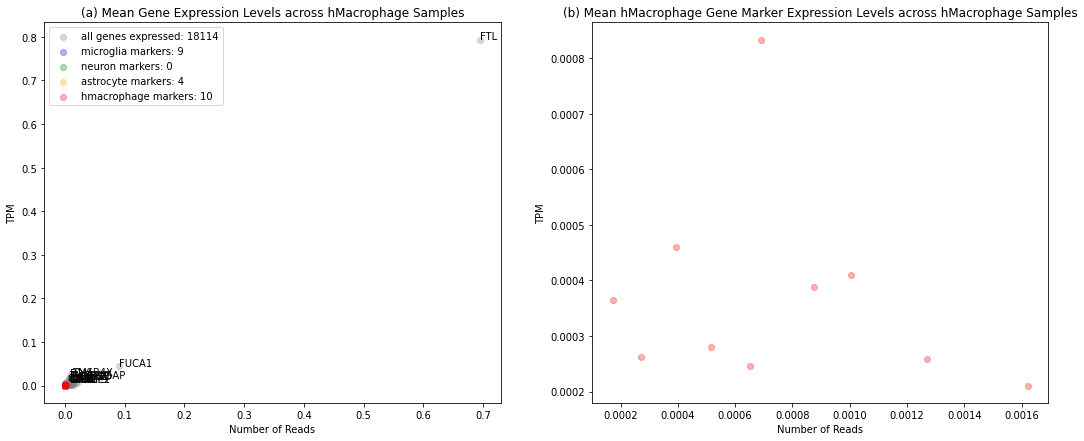

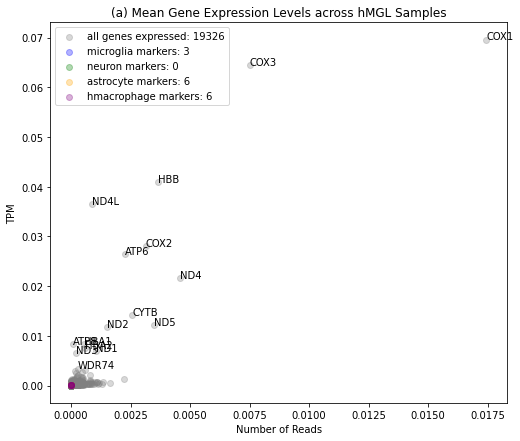

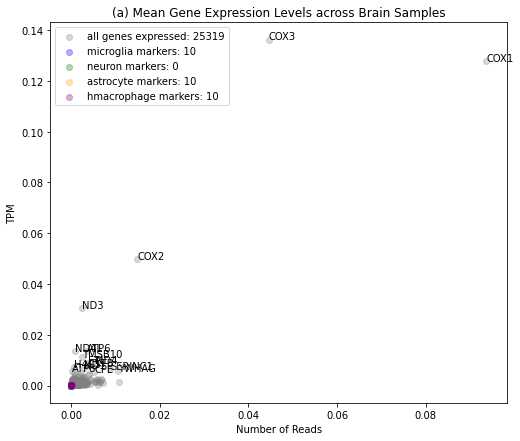

In [28]:
expr_dic = get_gene_expression(gene_markers=['microglia', 'neuron', 'astrocyte', 'hmacrophage'])
tissue_gene_expression_plot(gene_markers = ['microglia', 'neuron', 'astrocyte', 'hmacrophage'])

Index(['GeneName', 'H_VY.1015_S1511511_I.E.28', 'H_VY.11298_S1511545_I.D.20',
       'H_VY.11491_S1511526', 'H_VY.11787_S1512297_I.E.35',
       'H_VY.11964_S1512298_I.E.29', 'H_VY.12114_S1512416_I.D.24',
       'H_VY.12152_S1511976_V', 'H_VY.12152_S1512495', 'H_VY.12355_S1512490',
       ...
       'H_VY.CMRAPO_D1202607_I.B.9', 'H_VY.CSUE2P_D1202605_I.A.1',
       'H_VY.F1R54Y_D1202616_I.C.18', 'H_VY.IFNZ5I_S1511366_I.A.2',
       'H_VY.OFRI36_D1202612_I.B.12', 'H_VY.OJCMIG_D1202604_I.B.8',
       'H_VY.QNVRDM_D1202613_I.B.8', 'H_VY.UCCKJF_D1202615_I.B.7',
       'H_VY.W14OEI_S1512445_I.B.8', 'H_VY.Y1XG2W_D1202622_I.B.5'],
      dtype='object', length=154)

,H_VY.1015_S1511511_I.E.28,H_VY.11298_S1511545_I.D.20,H_VY.11491_S1511526,H_VY.11787_S1512297_I.E.35,H_VY.11964_S1512298_I.E.29,H_VY.12114_S1512416_I.D.24,H_VY.12152_S1511976_V,H_VY.12152_S1512495,H_VY.12355_S1512490,H_VY.12608_S1512320_I.D.19
GeneName,,,,,,,,,,
DAZ3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065984,0.069841
BPY2B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CDY1B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002452
DAZ2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017897,0.069841
DAZ1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070138,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
NEDD4L,83.439300,95.061300,85.409300,73.800300,81.259700,83.889100,87.936000,99.963200,86.528700,66.858200
ALPK2,0.081756,0.068694,0.035166,0.175701,0.081755,0.015985,0.105386,0.174646,0.179584,0.044653
CLDN16,2.129790,2.212590,1.317530,0.972728,1.441200,1.191660,1.908200,1.730840,0.807469,1.011070


Text(0, 0.5, 'Relative Cell Proportion')

<Figure size 432x288 with 0 Axes>

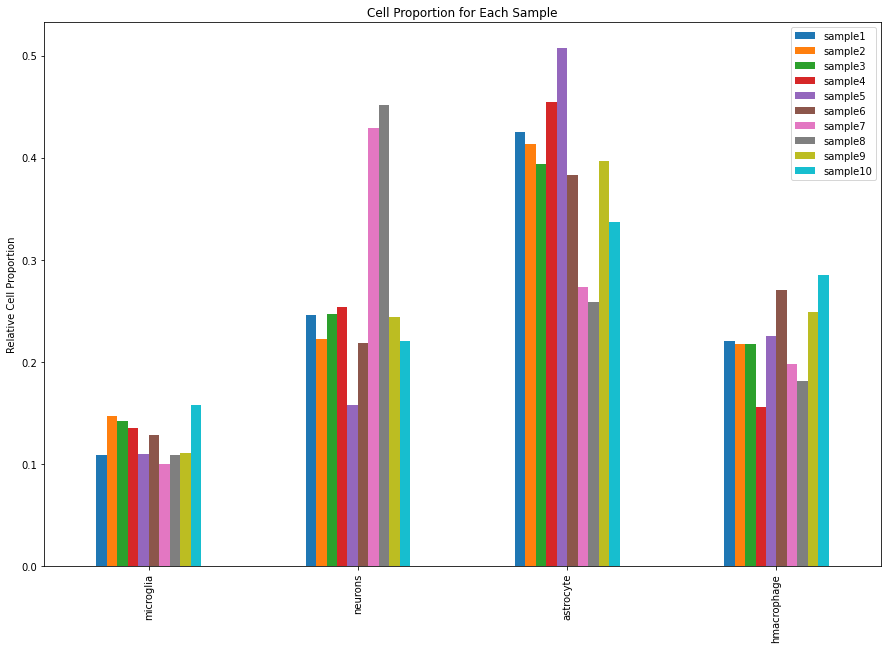

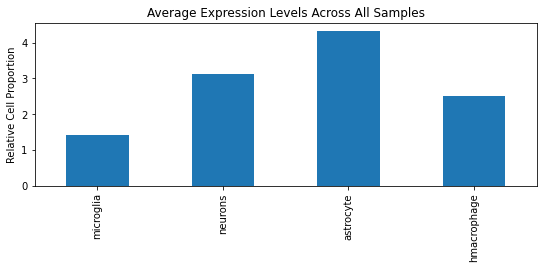

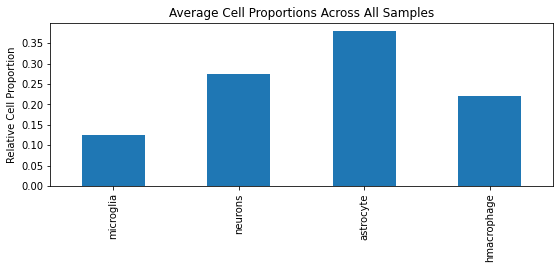

In [46]:
dragon_samples = pd.read_csv('Deconvolution_Salmon_tpm_gene_quantification.csv')

result_dic = {}
display(dragon_samples.columns)
selected_samples = dragon_samples.iloc[:, 0: 11]
selected_samples.index = selected_samples["GeneName"]
del selected_samples['GeneName']

display(selected_samples)
# pd.DataFrame([[0, 0],[0, 0],[0, 0],[0, 0]], index=result_dic["Organoid1"].keys(), columns=["TPM_Dependent", "NumReads_Dependent"])
cell_means = []
for cell, markers in cell_gene_markers.items():
    cell_means.append(np.array(selected_samples[selected_samples.index.isin(markers)].mean()))

deconv_result_df = pd.DataFrame(cell_means, index=cell_gene_markers.keys(), columns=selected_samples.columns)

plt.figure()
(deconv_result_df/deconv_result_df.sum()).plot.bar(figsize=(15, 10))
plt.title("Cell Proportion for Each Sample")
plt.ylabel("Relative Cell Proportion")
plt.legend(["sample1","sample2","sample3","sample4","sample5","sample6","sample7","sample8","sample9","sample10"])

plt.figure()
deconv_result_df.mean(axis=1).plot.bar(figsize=(9, 3))
plt.title("Average Expression Levels Across All Samples")
plt.ylabel("Relative Cell Proportion")

plt.figure()
(deconv_result_df.mean(axis=1)/deconv_result_df.mean(axis=1).sum()).plot.bar(figsize=(9, 3))
plt.title("Average Cell Proportions Across All Samples")
plt.ylabel("Relative Cell Proportion")
